In [2]:
import pandas as pd
import numpy as np
from datetime import date
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from multiprocessing import Pool, cpu_count
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
import duckdb



In [3]:
with duckdb.connect("file.db") as conn:
    with open("sql/sample_users.sql") as f:
        sample_users_sql = f.read()
    
    sample_users_df = conn.execute(sample_users_sql).df()

In [4]:
df = pd.read_csv("unduplicated_users.csv")
# df = sample_users_df
# df = pd.read_csv("sample_users.csv")

In [5]:

df

,did,handle,bio,created_at,letter
0,did:plc:ewvi7nxzyoun6zhxrhs64oiz,atproto.com,Social networking technology created by Bluesk...,2023-04-26 02:19:25.508000-04:00,a
1,did:plc:eon2iu7v3x2ukgxkqaf7e5np,safety.bsky.app,Sharing updates about trust and safety on Blue...,2023-07-17 17:54:28.741000-04:00,a
2,did:plc:a4pqq234yw7fqbddawjo7y35,theonion.com,America’s Finest News Source.\n\nA @globaltetr...,2023-04-29 08:21:21.353000-04:00,a
3,did:plc:oky5czdrnfjpqslsw2a5iclo,jay.bsky.team,"CEO of Bluesky, steward of AT Protocol. \n\nLe...",2022-11-17 01:31:40.296000-05:00,a
4,did:plc:tpg43qhh4lw4ksiffs4nbda3,jacob.gold,Former engineer @ Tech giant Bluesky\n\nMounta...,2023-01-04 13:08:01.779000-05:00,a
...,...,...,...,...,...
142497,did:plc:w2wplzhnux5aat5r7wldxo72,zender57.bsky.social,Fl resident for now. Love Democracy! Love Free...,2024-11-25 15:45:03.346000-05:00,z
142498,did:plc:72jvdiqe64pgqpkykzhnbr3x,zartina.bsky.social,NaN,2024-06-15 04:52:51.377000-04:00,z
142499,did:plc:bswtn7gbxmshlobyzfridiki,zomibom.bsky.social,24⭐they/them⭐2D Animator/Storyboards⭐\n\nCurre...,2023-10-13 21:43:48.053000-04:00,z
142500,did:plc:f2dbiwl57536ulzqzjnkjgk5,justinzwack.bsky.social,Lead Level Designer @KingArtGames | working on...,2023-09-08 04:01:33.042000-04:00,z


In [6]:
df.isna().sum()

did              0
handle           0
bio           4616
created_at       0
letter           0
dtype: int64

In [7]:
from datetime import datetime, date
import re
def transform_date(d):
    try:
        dt  = datetime.strptime(re.match(r"\d{4}-\d{2}-\d{2}", d).group(0), "%Y-%m-%d")
        return dt
    except ValueError:
        return np.nan

df["created_at"] =df["created_at"].apply(transform_date)

In [8]:

df["year-month"] =df["created_at"].apply(lambda x:f"{x.year}-{x.month}")

In [9]:
df = df.sort_values(by=["created_at"])
df

,did,handle,bio,created_at,letter,year-month
121134,did:plc:vpkhqolt662uhesyj6nxm7ys,why.bsky.team,"Technical advisor to @bluesky, first engineer ...",2022-11-16,w,2022-11
39269,did:plc:ragtjsm2j2vknwkz3zp4oxrd,pfrazee.com,Developer at Bluesky.,2022-11-16,f,2022-11
25570,did:plc:yk4dd2qkboz2yv6tpubpc6co,dholms.xyz,dreaming of protocol level sovereignty \n\nbsk...,2022-11-16,d,2022-11
25571,did:plc:l3rouwludahu3ui3bt66mfvj,divy.zone,🌀 bluesky team,2022-11-16,d,2022-11
114,did:plc:7axcqwj4roha6mqpdhpdwczx,wang.social,Anaconda Founder&Head of AI; created the PyDat...,2022-11-17,a,2022-11
...,...,...,...,...,...,...
113782,did:plc:oj5flxzbd3o32t5xzakosve7,centerforcooperativemedia.org.web.brid.gy,The mission of the Center for Cooperative Medi...,NaT,u,nan-nan
117075,did:plc:dfqnl3qgb73fxq6yltoxs2qh,victoriamonet.music-social.com.ap.brid.gy,Automated posts about new music and videos fro...,NaT,v,nan-nan
124872,did:plc:zcsop6sjapkb5vlahd24pddv,rappler.com.web.brid.gy,Rappler is the Philippines' leading digital me...,NaT,w,nan-nan
137594,did:plc:rduw5xjudpoylc6bid2b4we2,saltyuko27.bsky.social,【✦】𝙂𝙧𝙖𝙥𝙝𝙞𝙘 𝘿𝙚𝙨𝙞𝙜𝙣𝙚𝙧 ✱ 𝙔𝙤𝙪𝙩𝙖𝙞𝙩𝙚 ✱ 𝙑𝙩𝙪𝙗𝙚𝙧\n※ VGe...,NaT,y,nan-nan


In [10]:
data = df.groupby(by=["year-month"]).size()
weights = data / df.shape[0]
weights

year-month
2022-11    0.000211
2022-12    0.000168
2023-1     0.000842
2023-10    0.072631
2023-11    0.028210
2023-12    0.021494
2023-2     0.002772
2023-3     0.010526
2023-4     0.066245
2023-5     0.058154
2023-6     0.058034
2023-7     0.133324
2023-8     0.085592
2023-9     0.079844
2024-1     0.011649
2024-10    0.050413
2024-11    0.161022
2024-12    0.009516
2024-2     0.055887
2024-3     0.003656
2024-4     0.010449
2024-5     0.002281
2024-6     0.005305
2024-7     0.002119
2024-8     0.039915
2024-9     0.021431
2025-1     0.006554
2025-2     0.001663
nan-nan    0.000091
dtype: float64

In [11]:
rows = []
for i, row in enumerate(weights.items()):
    ym, weight = row
    if i == 0:
        sql = f"select '{ym}' as year_month, {weight:.4f} as value"
    else:
        sql = f"select '{ym}', {weight:.4f}"
    rows.append(sql)

rows = "\nunion all\n".join(rows)

print(f"""
with monthly_weights as (
    {rows}
)""")


with monthly_weights as (
    select '2022-11' as year_month, 0.0002 as value
union all
select '2022-12', 0.0002
union all
select '2023-1', 0.0008
union all
select '2023-10', 0.0726
union all
select '2023-11', 0.0282
union all
select '2023-12', 0.0215
union all
select '2023-2', 0.0028
union all
select '2023-3', 0.0105
union all
select '2023-4', 0.0662
union all
select '2023-5', 0.0582
union all
select '2023-6', 0.0580
union all
select '2023-7', 0.1333
union all
select '2023-8', 0.0856
union all
select '2023-9', 0.0798
union all
select '2024-1', 0.0116
union all
select '2024-10', 0.0504
union all
select '2024-11', 0.1610
union all
select '2024-12', 0.0095
union all
select '2024-2', 0.0559
union all
select '2024-3', 0.0037
union all
select '2024-4', 0.0104
union all
select '2024-5', 0.0023
union all
select '2024-6', 0.0053
union all
select '2024-7', 0.0021
union all
select '2024-8', 0.0399
union all
select '2024-9', 0.0214
union all
select '2025-1', 0.0066
union all
select '2025-2', 0.0

In [12]:
df["year-month"].unique()[7]

'2023-6'

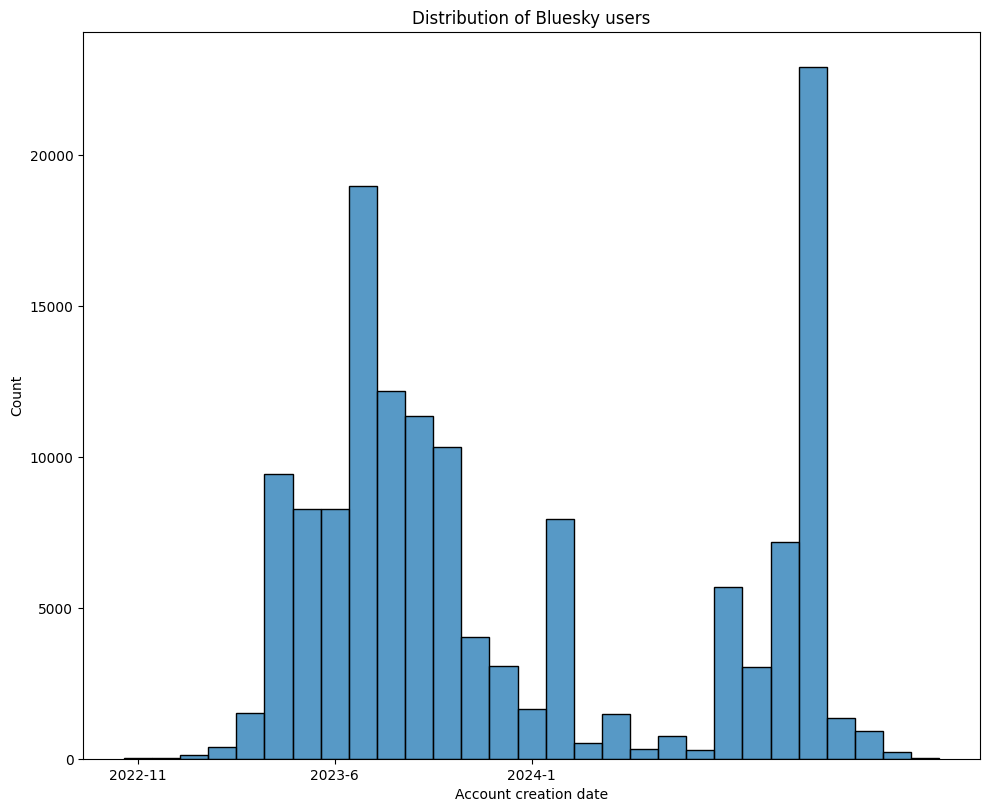

In [13]:


plt.figure(figsize=(10, 8))

sns.histplot(data=df, x="year-month")

# create ticks

idx = [i * 7 for i in range(3)]
plt.xticks(idx, df["year-month"].unique()[idx])
plt.tight_layout() 
plt.xlabel("Account creation date")
plt.title("Distribution of Bluesky users")
plt.show()

In [14]:
df["year-month"].unique()[idx[:4]]

array(['2022-11', '2023-6', '2024-1'], dtype=object)

In [15]:
sample_users_df

,did,handle,bio,created_at
0,did:plc:2xmwfpbesdqy3oa7mgjxryfb,kafekafei.bsky.social,I am here now 🔞🔞🔞,2023-08-26 17:56:29.118
1,did:plc:hvuh2mzvjpdzxwsutzfbvieu,wildlifegis.bsky.social,MGIS | Conservation GIS & Remote Sensing | Agr...,2023-08-31 15:24:31.038
2,did:plc:bfiewdcm26qhrtdvymrdcriz,jessicahullman.bsky.social,Ginni Rometty Prof @NorthwesternCS | Fellow @N...,2023-08-10 03:07:04.217
3,did:plc:qggcrjudops4dwwheuv443al,frases.bsky.social,E quando você menos esperar... tudo irá ficar ...,2023-08-07 21:39:24.510
4,did:plc:kuz7eo5kawfjjp35q2wtqp3s,heatherhaleyphd.bsky.social,historian | runner | plant & cat mom | views e...,2023-08-26 13:53:46.400
...,...,...,...,...
98416,did:plc:77bcdiuzashaqpjd5netptvg,itsluanababe.bsky.social,None,2023-03-02 23:22:34.171
98417,did:plc:rh27ne3ocj2ogg77j4ph3f4f,filipe.bsky.social,³³³ is the half of demon that i am\n\ninstagra...,2023-03-01 00:44:38.481
98418,did:plc:ijg6lryz6xrzwewif744o3vh,lucaswirgoski.bsky.social,como eu vim parar aqui eu só tenho 6 anos\n\n\...,2023-03-02 08:58:11.220
98419,did:plc:tsuomp67rg7plbrp5sqso7ib,hyperfekt.net,conscious oxymora. vagile & antiauthoritarian,2023-03-28 19:40:54.287


In [16]:
with duckdb.connect("file.db") as conn:

    conn.execute("""
    create view if not exists
    all_posts as select * from read_parquet('nborland_posts') union all select * from read_parquet('shawn_posts') union all select * from read_parquet('prithaj_posts');
    """)

    with open("sql/rolling_6_week_avg.sql") as f:
        rolling_avg_sql = f.read()
    
    rolling_avg_df = conn.execute(rolling_avg_sql).df()

In [17]:
rolling_avg_df

,author_did,post_date,post_count,rolling_6week_avg
0,did:plc:2224x6c53tqc6dpnbamce2yg,2022-01-01,0,0.000000
1,did:plc:2224x6c53tqc6dpnbamce2yg,2022-01-02,0,0.000000
2,did:plc:2224x6c53tqc6dpnbamce2yg,2022-01-03,0,0.000000
3,did:plc:2224x6c53tqc6dpnbamce2yg,2022-01-04,0,0.000000
4,did:plc:2224x6c53tqc6dpnbamce2yg,2022-01-05,0,0.000000
...,...,...,...,...
26975255,did:web:hugeblank.dev,2025-02-25,0,1.761905
26975256,did:web:hugeblank.dev,2025-02-26,1,1.714286
26975257,did:web:hugeblank.dev,2025-02-27,2,1.738095
26975258,did:web:hugeblank.dev,2025-02-28,2,1.738095


In [18]:
rolling_avg_df["author_did"].unique()

array(['did:plc:2224x6c53tqc6dpnbamce2yg',
       'did:plc:222h35q7urjpjafryjwqn3ae',
       'did:plc:223surfias2t3sgc3nlumah5', ...,
       'did:plc:zzxj3vqqljwopbbqhjr34ntb',
       'did:plc:zzxp45g5c5fma7yfpbzkf6au', 'did:web:hugeblank.dev'],
      dtype=object)

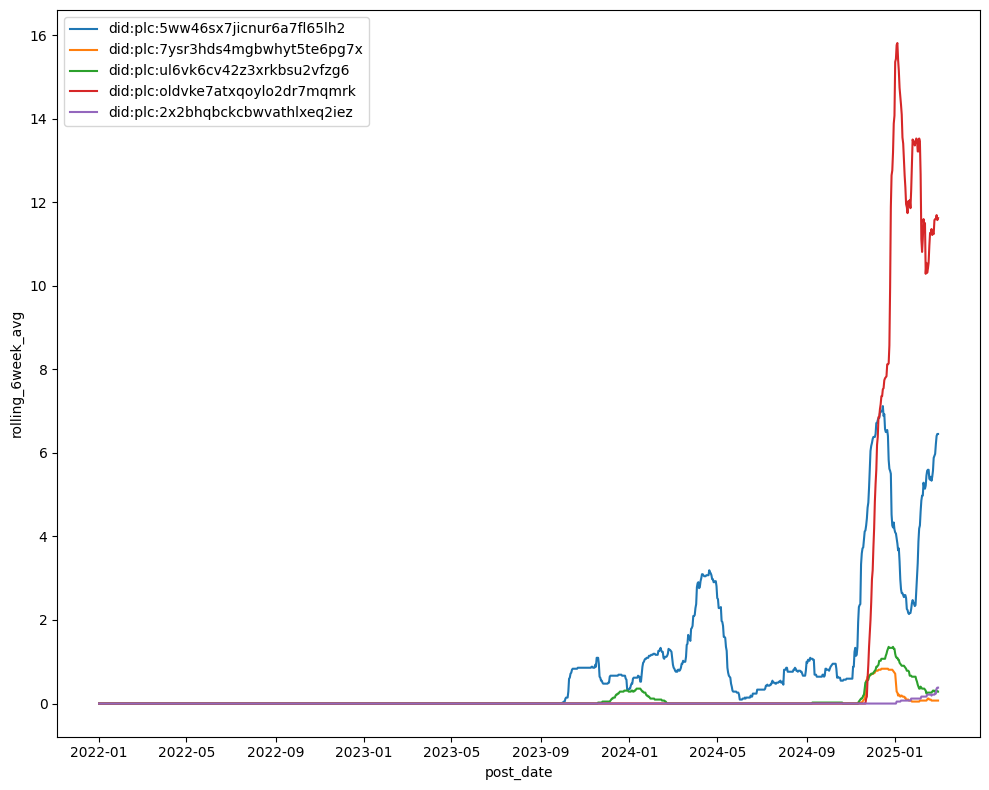

In [19]:


plt.figure(figsize=(10, 8))
random_sample = rolling_avg_df.sample(20)
for did in random_sample["author_did"].unique()[:5]:
    slice_df = rolling_avg_df[rolling_avg_df["author_did"] == did]
    sns.lineplot(data=slice_df, x="post_date", y="rolling_6week_avg", label=did)

# idx = [i * 7 for i in range(3)]
# plt.xticks(idx, rolling_avg_df["post_date"].unique()[idx])
plt.tight_layout() 

plt.legend()
plt.show()

In [20]:
X_data = rolling_avg_df.pivot_table(columns="post_date", index="author_did", values="rolling_6week_avg")
X_data

post_date,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2025-02-20,2025-02-21,2025-02-22,2025-02-23,2025-02-24,2025-02-25,2025-02-26,2025-02-27,2025-02-28,2025-03-01
author_did,,,,,,,,,,,,,,,,,,,,,
did:plc:2224x6c53tqc6dpnbamce2yg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.928571,6.880952,7.190476,7.452381,7.857143,7.952381,8.023810,8.833333,9.404762,9.452381
did:plc:222h35q7urjpjafryjwqn3ae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.666667,2.071429,2.166667,2.238095,2.214286,2.261905,2.214286,2.071429,2.047619,2.071429
did:plc:223surfias2t3sgc3nlumah5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.119048,1.166667,1.166667,1.595238,1.952381,2.095238,2.095238,2.119048,2.142857,2.142857
did:plc:224izruakrnberlqshv5kg2p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.357143,0.357143,0.357143,0.333333,0.285714,0.285714,0.285714,0.309524,0.309524,0.333333
did:plc:224jzjuk3s5kk3zzsezg643r,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
did:plc:zztbumucoio7gmtpwx4caxnf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.785714,5.452381,5.404762,5.166667,4.738095,4.714286,4.690476,4.428571,4.261905,4.261905
did:plc:zzwpcxqltcs5jfqyu4wnqmqu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.190476,0.190476,0.190476,0.166667,0.166667,0.166667,0.142857,0.142857,0.142857,0.142857
did:plc:zzxj3vqqljwopbbqhjr34ntb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.547619,0.571429,0.571429,0.571429,0.571429,0.595238,0.595238,0.690476,0.690476,0.690476


In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_data)

In [22]:
X_scaled

array([[-0.04144131, -0.03945456, -0.04260717, ...,  0.06372572,
         0.08596586,  0.08727771],
       [-0.04144131, -0.03945456, -0.04260717, ..., -0.22164866,
        -0.22288932, -0.22218186],
       [-0.04144131, -0.03945456, -0.04260717, ..., -0.21963899,
        -0.2188912 , -0.21918709],
       ...,
       [-0.04144131, -0.03945456, -0.04260717, ..., -0.27992935,
        -0.27986261, -0.28008074],
       [-0.04144131, -0.03945456, -0.04260717, ..., -0.28294387,
        -0.2828612 , -0.28307551],
       [-0.04144131, -0.03945456, -0.04260717, ..., -0.23571642,
        -0.23588323, -0.23216442]])

In [23]:

def hyperparam_dbscan(X_scaled):


    eps_values = np.linspace(1, 10, 20)
    min_samples_values = range(3, 10)

    best_score = -1
    best_params = None
    best_labels = None

    for eps in eps_values:
        for min_samples in min_samples_values:
            print(f"{eps};{min_samples}")
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(X_scaled)

            if len(set(labels)) > 1 and len(set(labels)) < len(X_scaled):
                try:
                    score = silhouette_score(X_scaled, labels)
                    if score > best_score:
                        best_score = score
                        best_params = (eps, min_samples)
                        best_labels = labels
                except:
                    continue  # sometimes silhouette fails for degenerate clusterings
    
    return best_params, best_score

In [24]:
result = hyperparam_dbscan(X_scaled)

1.0;3
1.0;4
1.0;5
1.0;6
1.0;7
1.0;8
1.0;9
1.4736842105263157;3
1.4736842105263157;4
1.4736842105263157;5
1.4736842105263157;6
1.4736842105263157;7
1.4736842105263157;8
1.4736842105263157;9
1.9473684210526314;3
1.9473684210526314;4
1.9473684210526314;5
1.9473684210526314;6
1.9473684210526314;7
1.9473684210526314;8
1.9473684210526314;9
2.4210526315789473;3
2.4210526315789473;4
2.4210526315789473;5
2.4210526315789473;6
2.4210526315789473;7
2.4210526315789473;8
2.4210526315789473;9
2.894736842105263;3
2.894736842105263;4
2.894736842105263;5
2.894736842105263;6
2.894736842105263;7
2.894736842105263;8
2.894736842105263;9
3.3684210526315788;3
3.3684210526315788;4
3.3684210526315788;5
3.3684210526315788;6
3.3684210526315788;7
3.3684210526315788;8
3.3684210526315788;9
3.8421052631578947;3
3.8421052631578947;4
3.8421052631578947;5
3.8421052631578947;6
3.8421052631578947;7
3.8421052631578947;8
3.8421052631578947;9
4.315789473684211;3
4.315789473684211;4
4.315789473684211;5
4.315789473684211;6
4.3

In [33]:
best_params, best_score = result
eps, min_samples = best_params

In [25]:
from sklearn.cluster import KMeans
k=2
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_
X_data["kmeans_cluster"] = labels

In [34]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
X_data["dbscan_cluster"] = dbscan.labels_

In [27]:
X_data["kmeans_cluster"]

author_did
did:plc:2224x6c53tqc6dpnbamce2yg    0
did:plc:222h35q7urjpjafryjwqn3ae    0
did:plc:223surfias2t3sgc3nlumah5    0
did:plc:224izruakrnberlqshv5kg2p    0
did:plc:224jzjuk3s5kk3zzsezg643r    0
                                   ..
did:plc:zztbumucoio7gmtpwx4caxnf    0
did:plc:zzwpcxqltcs5jfqyu4wnqmqu    0
did:plc:zzxj3vqqljwopbbqhjr34ntb    0
did:plc:zzxp45g5c5fma7yfpbzkf6au    0
did:web:hugeblank.dev               0
Name: kmeans_cluster, Length: 23335, dtype: int32

In [35]:
X_data["dbscan_cluster"].unique()

array([ 0, -1])

In [36]:
X_data["dbscan_cluster"].value_counts()

dbscan_cluster
 0    22075
-1     1260
Name: count, dtype: int64

In [41]:

def plot_clusters(clustering_algorithm, labels):
    plt.figure(figsize=(10, 8))


    INVITE_ONLY_LAUNCH_DATE = date(2023,2,1)
    PUBLIC_LAUNCH_DATE = date(2024,2,6)
    ELECTION_DATE = date(2024, 11, 5)
    ax = plt.gca()
    filtered_rolling_avg_df = rolling_avg_df[(rolling_avg_df["post_date"].dt.year >= 2022) & (rolling_avg_df["post_date"].dt.year < 2026)]
    for cluster in labels:
        dids = X_data[X_data[f"{clustering_algorithm}_cluster"] == cluster].index
        print(f"Size of cluster {cluster} = {len(dids)}")
        cluster_df = filtered_rolling_avg_df[filtered_rolling_avg_df["author_did"].isin(dids)]
        sns.lineplot(data=cluster_df, x="post_date", y="rolling_6week_avg", label=cluster)

    plt.axvline(x=PUBLIC_LAUNCH_DATE, color="red", ls=":")
    plt.axvline(x=INVITE_ONLY_LAUNCH_DATE, color="red", ls=":")
    plt.axvline(x=ELECTION_DATE, color="red", ls=":")


    ylim = ax.get_ylim()
    y_top = ylim[1] + 1

    ax.text(PUBLIC_LAUNCH_DATE, y_top, 'Public launch', color='red', ha='center', va='bottom', rotation=90)
    ax.text(INVITE_ONLY_LAUNCH_DATE, y_top, 'Invite-only launch', color='red', ha='center', va='bottom', rotation=90)
    ax.text(ELECTION_DATE, y_top, '2024 US election', color='red', ha='center', va='bottom', rotation=90)

    plt.title(clustering_algorithm)
    plt.xlabel("Date")
    plt.ylabel("Rolling 6-week averages of number of posts")
    plt.tight_layout()
    plt.legend()
    plt.show()


Size of cluster 0 = 23033
Size of cluster 1 = 302


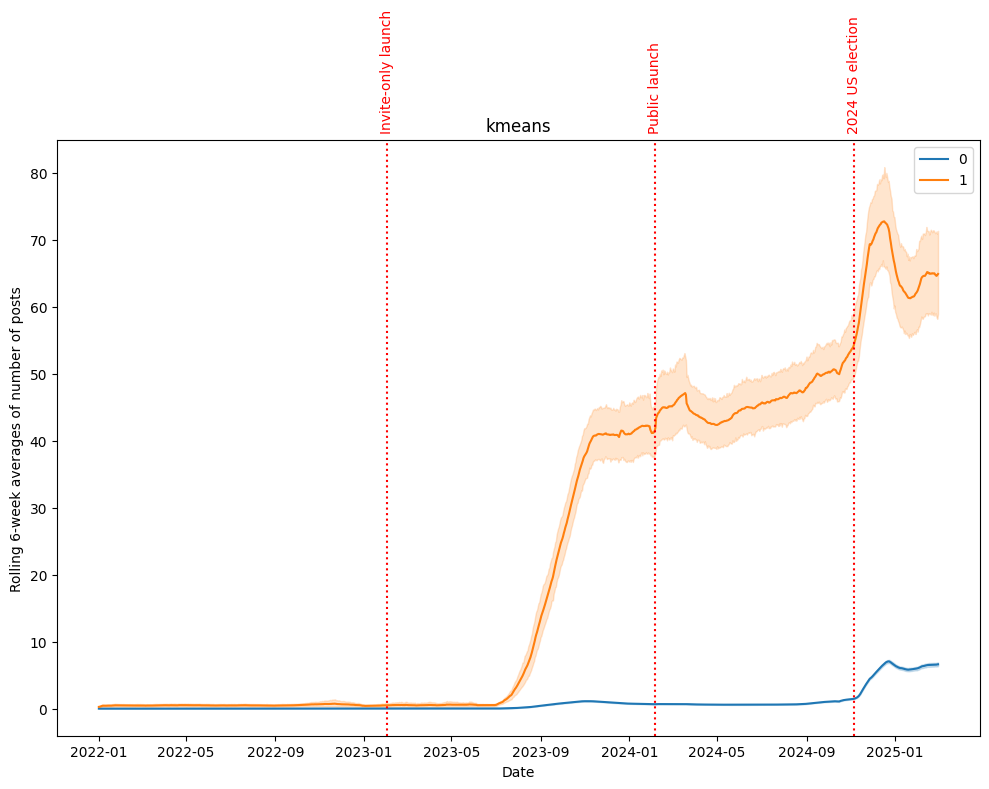

In [43]:
plot_clusters("kmeans", [0, 1])

Size of cluster 0 = 22075
Size of cluster -1 = 1260


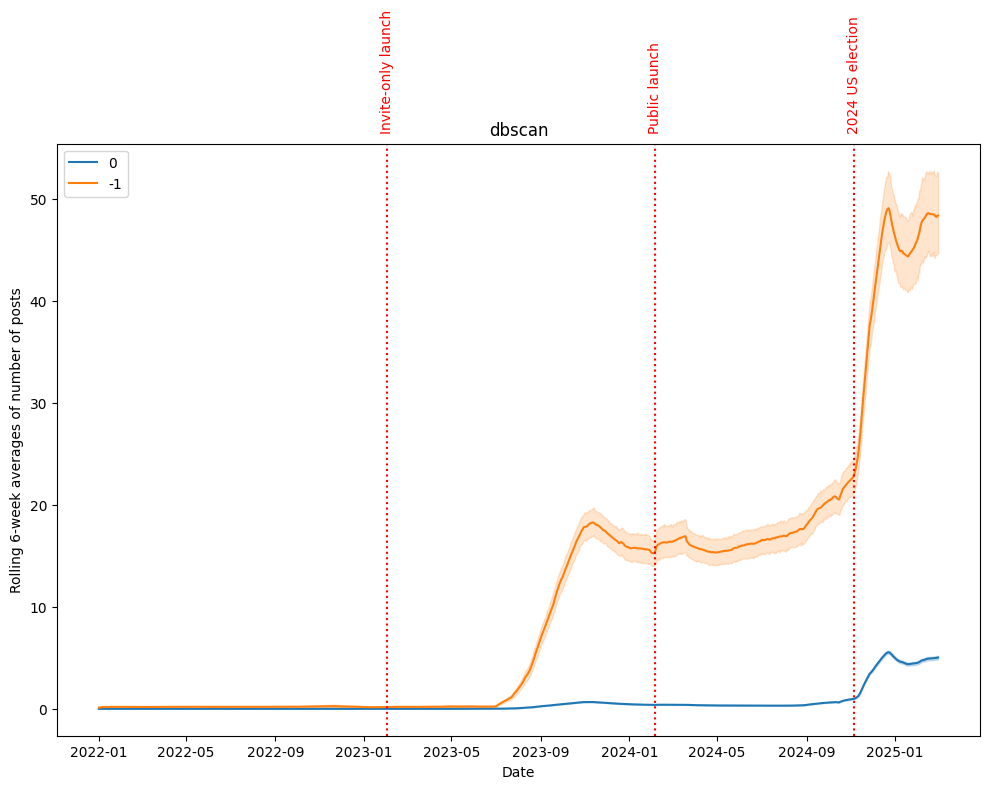

In [42]:
plot_clusters("dbscan", [0, -1])

In [46]:
X_data.groupby("kmeans_cluster").size() 

kmeans_cluster
0    23033
1      302
dtype: int64

In [47]:

X_data.groupby("dbscan_cluster").size()

dbscan_cluster
-1     1260
 0    22075
dtype: int64

In [48]:
silhouette_score(X_scaled, X_data["dbscan_cluster"])

np.float64(0.8627878129875305)

In [49]:

silhouette_score(X_scaled, X_data["kmeans_cluster"])

np.float64(0.9327578030147806)

In [ ]:
X_data[X_data["cluster"] == 1]

post_date,2022-01-01 00:00:00,2022-01-02 00:00:00,2022-01-03 00:00:00,2022-01-04 00:00:00,2022-01-05 00:00:00,2022-01-06 00:00:00,2022-01-07 00:00:00,2022-01-08 00:00:00,2022-01-09 00:00:00,2022-01-10 00:00:00,...,2025-03-16 00:00:00,2025-03-17 00:00:00,2025-03-18 00:00:00,2025-03-19 00:00:00,2025-03-20 00:00:00,2025-03-21 00:00:00,2025-03-22 00:00:00,2025-03-23 00:00:00,2025-04-04 00:00:00,cluster
author_did,,,,,,,,,,,,,,,,,,,,,
did:plc:2pdsoq5tcwsxyou3xrtwm7fd,4.761905,0.000000,4.547619,0.000000,0.000000,4.500000,4.428571,0.000000,4.428571,4.428571,...,0.000000,5.880952,5.690476,5.952381,6.404762,6.214286,6.095238,0.0,0.0,1
did:plc:33fiaaotsgg6fqerk2xx452w,4.190476,4.166667,4.166667,4.142857,4.047619,4.023810,3.928571,3.928571,4.047619,4.047619,...,11.095238,11.214286,10.714286,10.619048,10.595238,10.714286,10.690476,0.0,0.0,1
did:plc:3bbriohzj4twjioi2emlsnh5,5.238095,5.285714,5.142857,0.000000,5.166667,5.333333,5.452381,5.619048,5.714286,5.738095,...,11.880952,12.095238,12.214286,12.333333,11.904762,0.000000,0.000000,0.0,0.0,1
did:plc:54pmxdpfenextbwaipkpzxio,4.357143,4.428571,4.500000,4.476190,4.738095,4.785714,4.880952,4.952381,5.119048,5.166667,...,3.714286,3.595238,3.571429,0.000000,3.571429,0.000000,0.000000,0.0,0.0,1
did:plc:c4vrlto23ppwquv6om5u72pf,14.904762,14.928571,14.690476,14.690476,14.690476,14.928571,14.976190,15.000000,15.166667,15.285714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1
did:plc:cdgkmuwkzes6dgsw6rc23c3b,3.642857,3.690476,3.714286,3.714286,3.833333,3.809524,3.928571,4.000000,4.071429,4.047619,...,0.000000,3.547619,3.642857,3.547619,0.000000,0.000000,0.000000,0.0,0.0,1
did:plc:cihnolm6dnbvzishs54m2pxy,7.595238,7.666667,7.666667,7.833333,7.571429,7.690476,7.595238,7.452381,7.404762,7.261905,...,7.904762,8.238095,8.142857,8.214286,0.000000,0.000000,0.000000,0.0,0.0,1
did:plc:dohgtdoxwbvy5c6oo2bksqga,6.833333,6.880952,6.904762,6.976190,7.142857,7.261905,7.428571,7.452381,0.000000,7.547619,...,0.000000,5.095238,5.142857,5.119048,5.166667,5.309524,5.261905,0.0,0.0,1
did:plc:f233gewrunwymvpw6ymdxwrv,5.000000,5.000000,5.000000,5.047619,4.976190,4.976190,4.928571,4.880952,4.952381,5.071429,...,29.595238,29.214286,29.190476,29.976190,29.880952,0.000000,0.000000,0.0,0.0,1


In [ ]:

X_data[X_data["cluster"] == 2]

post_date,2022-01-01 00:00:00,2022-01-02 00:00:00,2022-01-03 00:00:00,2022-01-04 00:00:00,2022-01-05 00:00:00,2022-01-06 00:00:00,2022-01-07 00:00:00,2022-01-08 00:00:00,2022-01-09 00:00:00,2022-01-10 00:00:00,...,2025-03-16 00:00:00,2025-03-17 00:00:00,2025-03-18 00:00:00,2025-03-19 00:00:00,2025-03-20 00:00:00,2025-03-21 00:00:00,2025-03-22 00:00:00,2025-03-23 00:00:00,2025-04-04 00:00:00,cluster
author_did,,,,,,,,,,,,,,,,,,,,,
did:plc:225g4y2e35b4fylvbsbe752f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,77.023810,77.071429,77.095238,78.619048,78.500000,78.119048,0.000000,0.0,0.0,2
did:plc:23frguzjyakriewsvsxd2oyo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.380952,23.785714,23.119048,23.000000,0.000000,0.000000,0.000000,0.0,0.0,2
did:plc:2hp4v7eqwthqhepmqupmxtdo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2
did:plc:2j2rh2eid2bcgyzzloewu4bt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.809524,39.880952,40.547619,41.642857,42.000000,43.333333,42.952381,0.0,0.0,2
did:plc:2jtya2svlwcpos5drug4lsvx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,272.238095,272.285714,277.404762,280.928571,278.571429,270.023810,0.000000,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
did:plc:znwoq3ignunq66z3ceia4tij,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51.214286,51.547619,52.023810,53.880952,54.928571,56.357143,0.000000,0.0,0.0,2
did:plc:zp5u3bvx7sqbkvivjtp6yjna,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,211.333333,216.547619,220.952381,224.119048,0.000000,0.000000,0.000000,0.0,0.0,2
did:plc:zqqapvertktoeoeayoinfbgd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44.642857,44.142857,43.666667,42.714286,42.738095,42.595238,42.047619,0.0,0.0,2


In [ ]:
with duckdb.connect("file.db") as conn:
    norm_users_df = conn.execute(""" with custom_date_range as (
       select
        unnest(generate_series(timestamp '2022-01-01', timestamp '2025-03-01', interval '1 day'))::date as post_date
   )select 
           a.author_did,
           b.post_date::date as post_date,
            ap.cid
       from (select distinct author_did from all_posts) a
       cross join custom_date_range b
        left join all_posts ap on ap.created_at::date = b.post_date and ap.author_did = a.author_did
    ;""").df()

In [ ]:
norm_users_df[norm_users_df["author_did"] == "did:plc:ashct5sqclca45wo4j5hy3hq"].sort_values(by=["post_date"], ascending=True)

,author_did,post_date,cid


In [ ]:
sample_users_df = pd.read_csv("sample_users.csv")

In [ ]:
all_posts_df = sample_users_df[sample_users_df["did"].isin(rolling_avg_df["author_did"].unique())]

In [ ]:

all_posts_df["created_at"] =all_posts_df["created_at"].apply(transform_date)

/var/folders/bt/_zgbcn7517lfmt__0z378d580000gn/T/ipykernel_11632/996258439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_posts_df["created_at"] =all_posts_df["created_at"].apply(transform_date)


In [ ]:
all_posts_df["year"] = all_posts_df["created_at"].dt.year
all_posts_df["month"] = all_posts_df["created_at"].dt.month
all_posts_df["ym"] = all_posts_df["created_at"].apply(lambda x:f"{x.year}-{x.month}")

/var/folders/bt/_zgbcn7517lfmt__0z378d580000gn/T/ipykernel_11632/3818551947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_posts_df["year"] = all_posts_df["created_at"].dt.year
/var/folders/bt/_zgbcn7517lfmt__0z378d580000gn/T/ipykernel_11632/3818551947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_posts_df["month"] = all_posts_df["created_at"].dt.month
/var/folders/bt/_zgbcn7517lfmt__0z378d580000gn/T/ipykernel_11632/3818551947.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

In [ ]:
all_posts_df

,did,handle,bio,created_at,year,month,ym
0,did:plc:ooehugjick2vkzwlr64lephm,haleaziz.bsky.social,I cover DHS and immigration policy for the New...,2024-11-18,2024,11,2024-11
1,did:plc:qy3kg6jvtlhenv5ojqurynwh,joshuacroke.bsky.social,Founder of 🏳️‍🌈 queerforcities.com / 🌈loveyour...,2024-11-15,2024,11,2024-11
2,did:plc:ibqwicj6ersmvw36yldikozx,inspiringtimmy.bsky.social,Best known for watching the Queen's Gambit fro...,2024-11-06,2024,11,2024-11
4,did:plc:f4ultoamz3y2m4drcjvhoecu,wilmonstouches.bsky.social,"same name but not rosh‘s ex | #OMAR : ”oh, tha...",2024-11-15,2024,11,2024-11
5,did:plc:yzhdirwmonvaezndwnssoosd,kerrieneet.bsky.social,Wild places in the SW and beyond. Where to go?...,2024-11-20,2024,11,2024-11
...,...,...,...,...,...,...,...
68342,did:plc:67yljp3x2ggfmtouqhzm23ax,quigonejinn.bsky.social,NaN,2023-07-25,2023,7,2023-7
68343,did:plc:64vgrlkpc25gq7dzgv4wk4fz,raywillmott.bsky.social,Some Welsh Brand Manager in games @rawfury.bsk...,2023-07-23,2023,7,2023-7
68344,did:plc:ld6amztvyqa6dkyfpuw7agz3,madrigal.bsky.social,"I have a shiny, smooth coat and a precise, int...",2023-07-04,2023,7,2023-7
68345,did:plc:ifcposy3e6frphvetobi7mva,foxpopvli.bsky.social,"🔸 Anthros, Cars and Nostalgia\n🔸 100% Natural ...",2023-07-19,2023,7,2023-7


<Axes: xlabel='ym', ylabel='Count'>

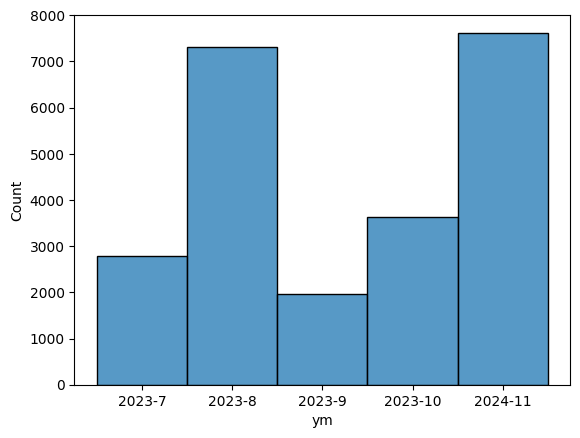

In [ ]:
sns.histplot(data=all_posts_df.sort_values(by=["year", "month"]), x="ym")

In [ ]:
all_posts_df.groupby("ym").size()

ym
2023-10    3642
2023-7     2782
2023-8     7314
2023-9     1975
2024-11    7622
dtype: int64

In [50]:
X_data.reset_index()[["author_did", "kmeans_cluster", "dbscan_cluster"]].to_csv("cluster_labels.csv", index=False)